In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
pip install -U imbalanced-learn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.4 MB/s eta 0:00:00


Mounted at /content/drive


100%|===================| 546/548 [02:24<00:00]       

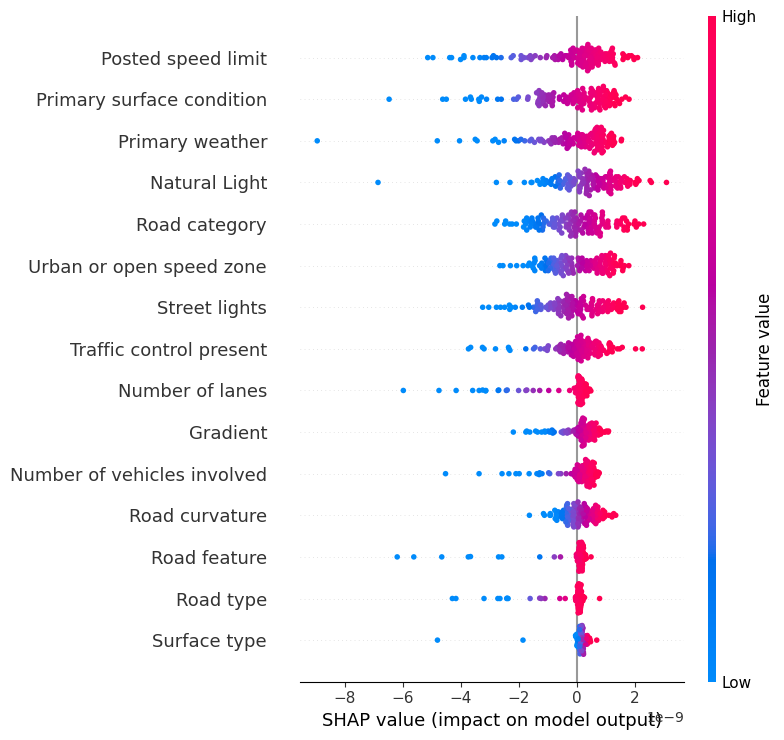

<Figure size 800x1000 with 0 Axes>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import csv



from google.colab import drive
drive.mount('/content/drive')

# Define the CSV file path in Google Drive
csv_file_path = '/content/drive/My Drive/Cleaned_data.csv'

# Initialize an empty list to store the rows
rows = []

# Open the file and read it with the csv.reader
try:
    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            rows.append(row)
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

# Convert the list of rows to a DataFrame if rows were read successfully
if rows:
    data = pd.DataFrame(rows[1:], columns=rows[0])

# List of specific features for SHAP analysis
feature_list = [ 'Road category',
                'Number of vehicles involved', 'Urban or open speed zone', 'Posted speed limit',
                'Road curvature', 'Road feature', 'Gradient', 'Surface type',
                'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
                'Primary surface condition', 'Natural Light', 'Primary weather',]

# Ensure only the relevant columns are used
data = data[feature_list + ['Crash severity']].dropna()

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(data.drop('Crash severity', axis=1))
y = data['Crash severity']

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier with default parameters
rf_clf = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Create a SHAP Explainer
explainer = shap.Explainer(rf_clf, X_train)

# Sample a subset of the test set for SHAP analysis
sampled_X_test = X_test.sample(frac=.01, random_state=42)

# Calculate SHAP Values for the sampled test set
shap_values = explainer.shap_values(sampled_X_test)

# Function to aggregate SHAP values for the original features before one-hot encoding
def aggregate_shap_values_for_original_features(shap_values, sampled_X_test, feature_list):
    # Sum the SHAP values if they are from a multi-class classifier
    if isinstance(shap_values, list):
        shap_values = np.sum(np.array(shap_values), axis=0)

    # Initialize an array to store the aggregated SHAP values
    aggregated_shap_values = np.zeros((sampled_X_test.shape[0], len(feature_list)))

    for i, feature in enumerate(feature_list):
        # Find all one-hot encoded columns for this feature
        feature_columns = [col for col in sampled_X_test.columns if col.startswith(feature)]

        # Sum the SHAP values for these columns
        feature_shap_values = shap_values[:, [sampled_X_test.columns.get_loc(col) for col in feature_columns]].sum(axis=1)

        # Assign the summed SHAP values to the corresponding column in the aggregated SHAP values array
        aggregated_shap_values[:, i] = feature_shap_values

    return aggregated_shap_values

# Aggregate SHAP values
aggregated_shap_values = aggregate_shap_values_for_original_features(shap_values, sampled_X_test, feature_list)

# Create a DataFrame for the aggregated SHAP values with correct feature names
aggregated_shap_df = pd.DataFrame(aggregated_shap_values, columns=feature_list)

# Plot the summary with aggregated SHAP values
shap.summary_plot(aggregated_shap_values, features=aggregated_shap_df, feature_names=feature_list, plot_type="dot")

# Customize the plot size and show it
plt.gcf().set_size_inches(8, 10)
plt.show()





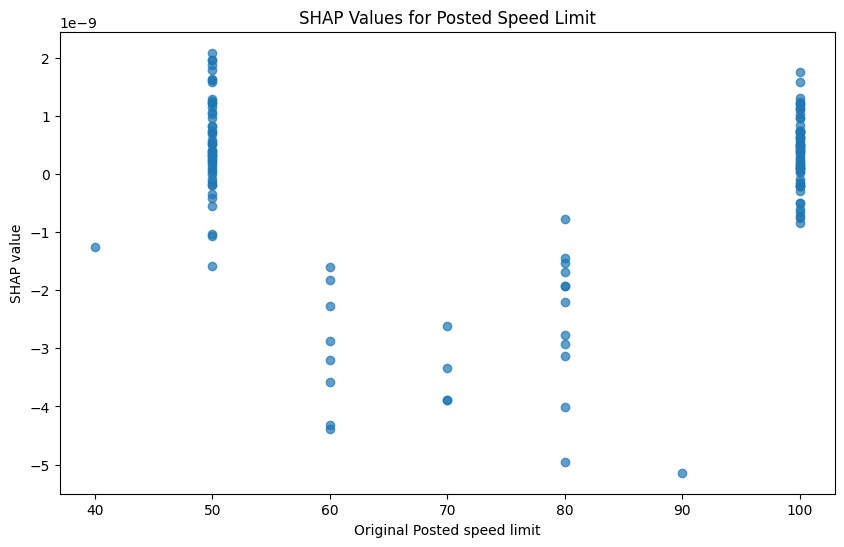

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Function to reverse one-hot encoding and reconstruct the original feature
def reverse_one_hot(df, feature_columns, original_feature_name):
    for col in feature_columns:
        df.loc[df[col] == 1, original_feature_name] = col.split('_')[-1]
    return df[original_feature_name].astype(float)  # Convert to float if the original feature was numeric

# Define the lists of column names for 'Posted speed limit'
posted_speed_limit_columns = [col for col in sampled_X_test.columns if col.startswith("Posted speed limit_")]

# Reverse one-hot encoding for 'Posted speed limit'
sampled_X_test['Original Posted speed limit'] = reverse_one_hot(sampled_X_test, posted_speed_limit_columns, 'Posted speed limit')

# Extract SHAP values for 'Posted speed limit'
posted_speed_limit_shap_values = aggregated_shap_df['Posted speed limit'].values

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for 'Posted speed limit' SHAP values
plt.scatter(sampled_X_test['Original Posted speed limit'], posted_speed_limit_shap_values, alpha=0.7)

# Setting plot labels and title
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit')

# Show the plot
plt.show()


100%|===================| 547/548 [02:24<00:00]       

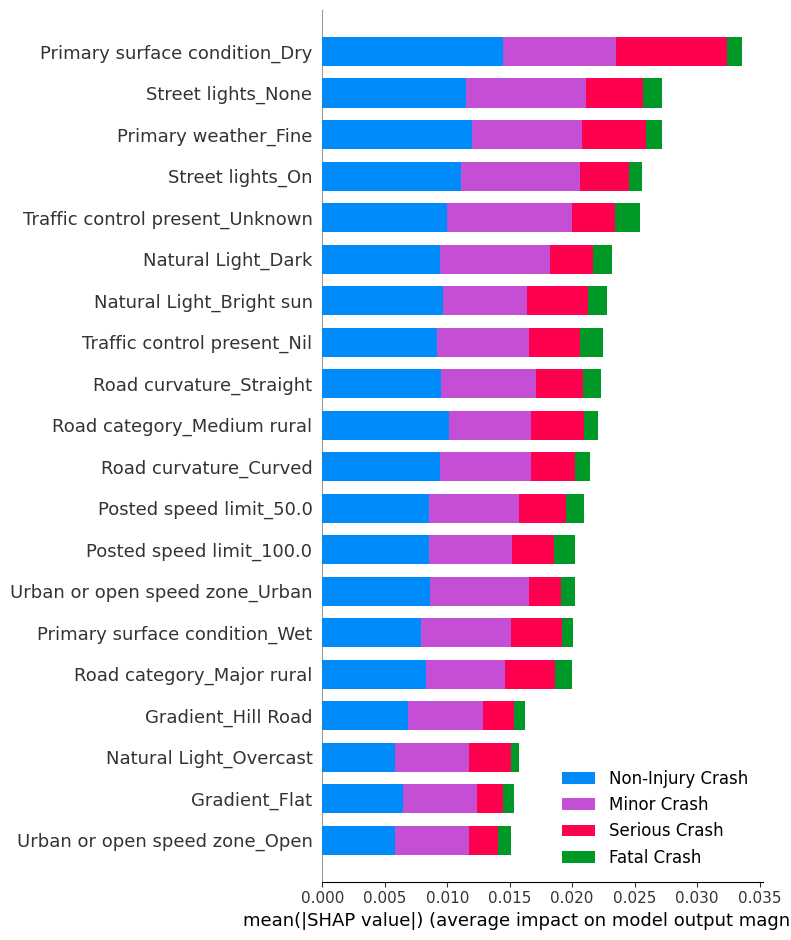

In [ ]:

# Initialize a SHAP explainer with the RandomForest model and training data
explainer = shap.Explainer(rf_clf, X_train)

# Sample a subset of the test set for SHAP analysis
sampled_X_test = X_test.sample(frac=0.01, random_state=42)

# Calculate SHAP Values for the sampled test set
shap_values = explainer.shap_values(sampled_X_test)

# We will generate the summary plot for the entire test set to show the crash severity as labels
# Generate a SHAP summary plot
shap.summary_plot(shap_values, sampled_X_test, plot_type="bar", class_names=rf_clf.classes_)

 99%|===================| 541/548 [01:30<00:01]       

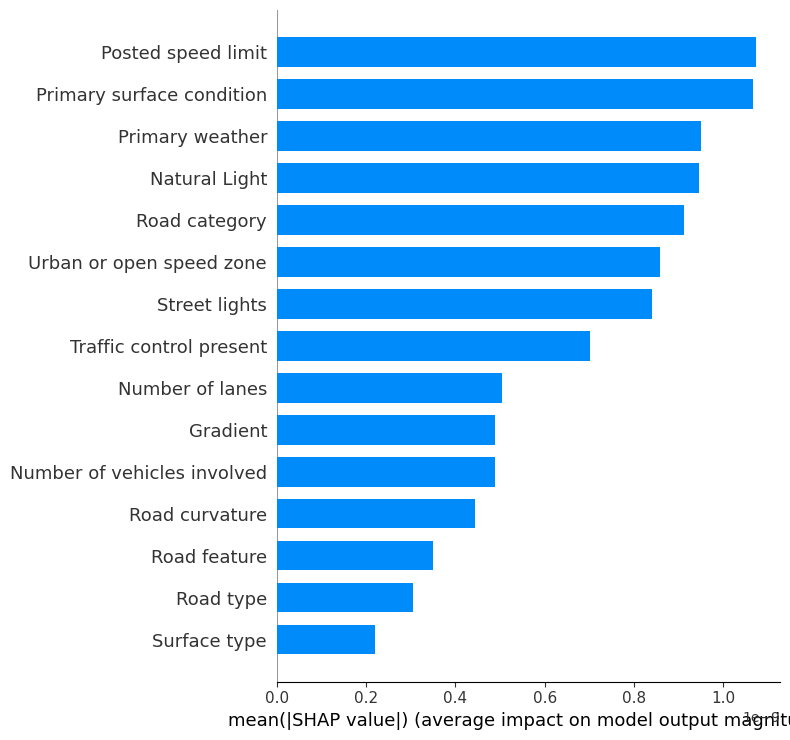

<Figure size 800x1000 with 0 Axes>

In [ ]:
# Calculate SHAP Values for the sampled test set
shap_values = explainer.shap_values(sampled_X_test)

# Function to aggregate SHAP values for the original features before one-hot encoding
def aggregate_shap_values_for_original_features(shap_values, sampled_X_test, feature_list):
    # Sum the SHAP values if they are from a multi-class classifier
    if isinstance(shap_values, list):
        shap_values = np.sum(np.array(shap_values), axis=0)

    # Initialize an array to store the aggregated SHAP values
    aggregated_shap_values = np.zeros((sampled_X_test.shape[0], len(feature_list)))

    for i, feature in enumerate(feature_list):
        # Find all one-hot encoded columns for this feature
        feature_columns = [col for col in sampled_X_test.columns if col.startswith(feature)]

        # Sum the SHAP values for these columns
        feature_shap_values = shap_values[:, [sampled_X_test.columns.get_loc(col) for col in feature_columns]].sum(axis=1)

        # Assign the summed SHAP values to the corresponding column in the aggregated SHAP values array
        aggregated_shap_values[:, i] = feature_shap_values

    return aggregated_shap_values

# Aggregate SHAP values
aggregated_shap_values = aggregate_shap_values_for_original_features(shap_values, sampled_X_test, feature_list)

# Create a DataFrame for the aggregated SHAP values with correct feature names
aggregated_shap_df = pd.DataFrame(aggregated_shap_values, columns=feature_list)

# Plot the summary with aggregated SHAP values
shap.summary_plot(aggregated_shap_values, features=aggregated_shap_df, feature_names=feature_list, plot_type="bar")

# Customize the plot size and show it
plt.gcf().set_size_inches(8, 10)
plt.show()

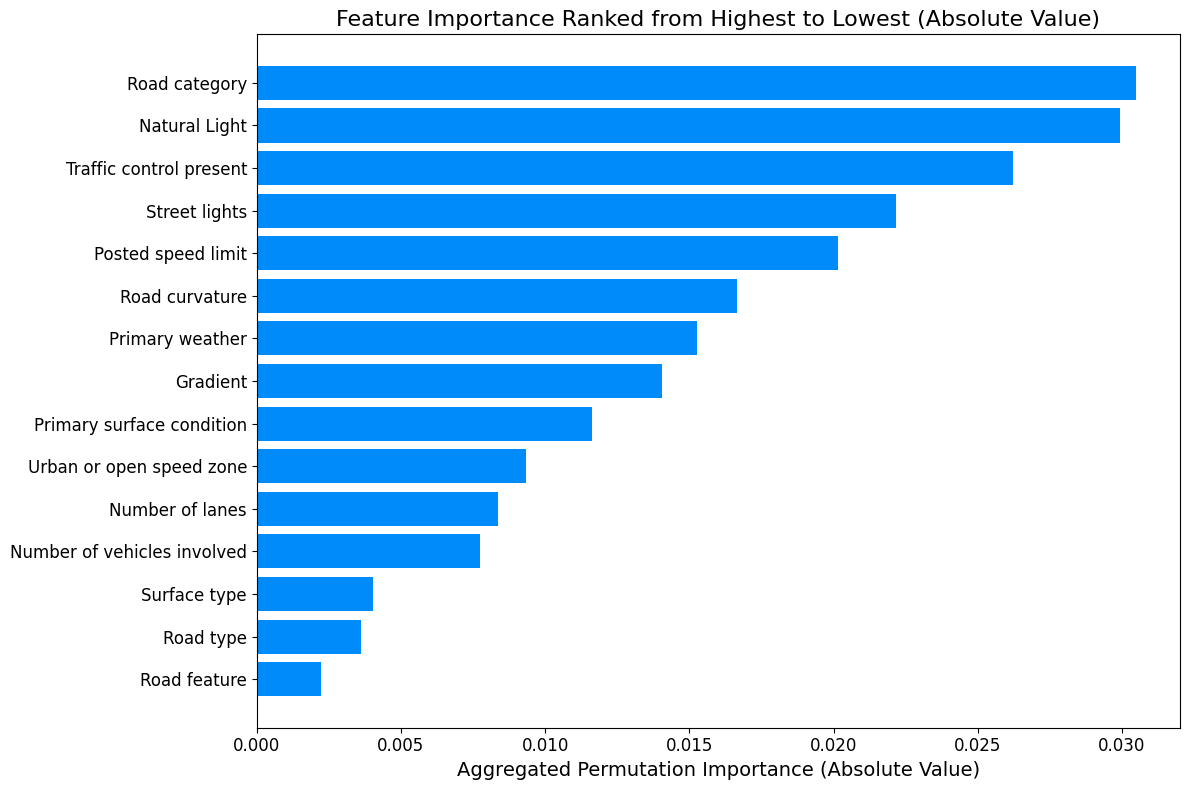

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming your Random Forest model is named rf_clf
# and you already have X_test and y_test from your previous code

# Sample 20% of the test set
X_test_sampled = X_test.sample(frac=.2, random_state=42)
y_test_sampled = y_test.loc[X_test_sampled.index]

# Calculate permutation importance on the sampled data
perm_importance = permutation_importance(
    rf_clf, X_test_sampled, y_test_sampled, n_repeats=15, random_state=42, n_jobs=1
)

# Map one-hot encoded feature names back to original feature names
original_feature_importances = {}
for i, imp in enumerate(perm_importance.importances_mean):
    # Assume the original feature name is the part before the first underscore '_'
    feature_name = X_test_sampled.columns[i]
    original_feature = feature_name.split('_')[0] if '_' in feature_name else feature_name
    if original_feature not in original_feature_importances:
        original_feature_importances[original_feature] = 0
    original_feature_importances[original_feature] += imp

# Sort the features by their importances in descending order of their absolute values
sorted_importances = sorted(original_feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_feature_names, sorted_importances = zip(*sorted_importances)

# Convert importances to absolute values for plotting
sorted_importances = np.abs(sorted_importances)

# Define the color in RGBA format and convert it to RGB format normalized to [0, 1]
bar_color = (0/255, 139/255, 251/255)  # Alpha value is not needed for bar color

# Styling changes
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center', color=bar_color)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names, fontsize=12, fontname='Arial')
plt.xticks(fontsize=12, fontname='Arial')
plt.xlabel("Aggregated Permutation Importance (Absolute Value)", fontsize=14, fontname='Arial')
plt.title("Feature Importance Ranked from Highest to Lowest (Absolute Value)", fontsize=16, fontname='Arial')
plt.gca().invert_yaxis()  # This will now display the most important feature at the top
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

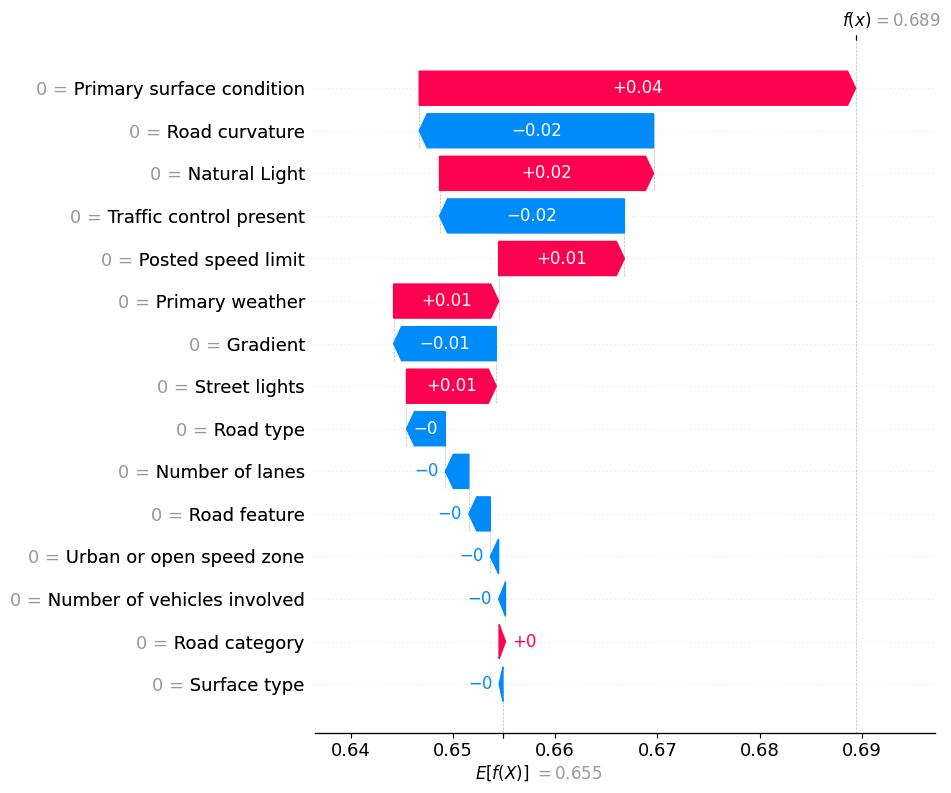

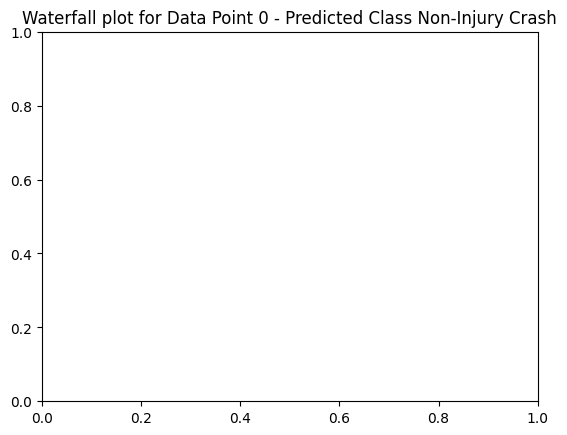

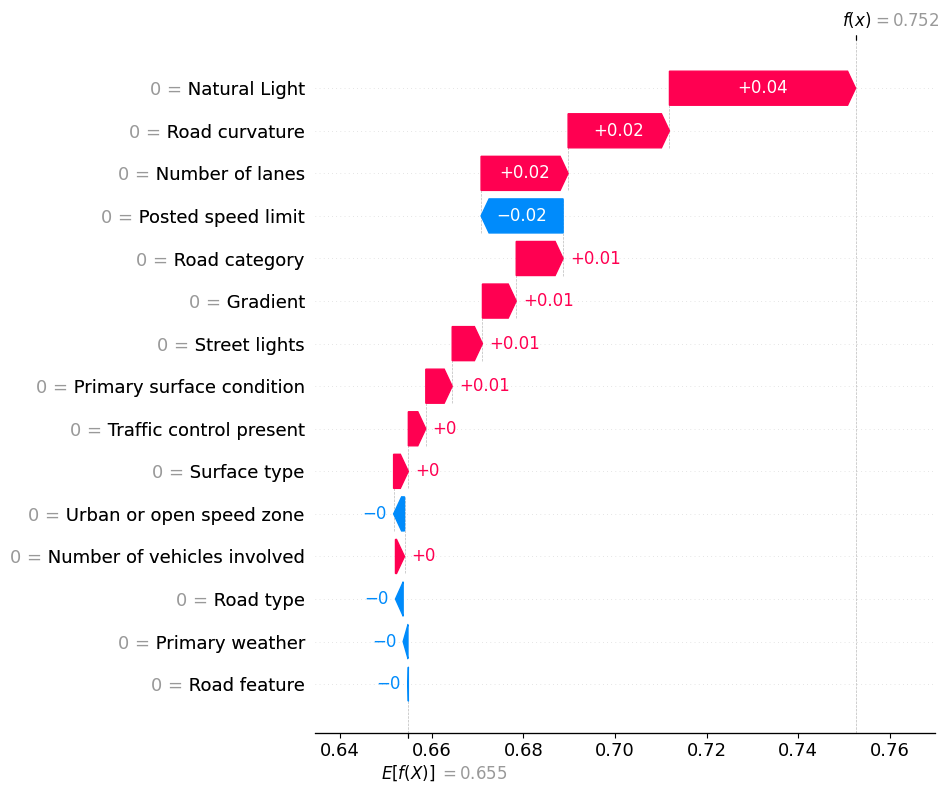

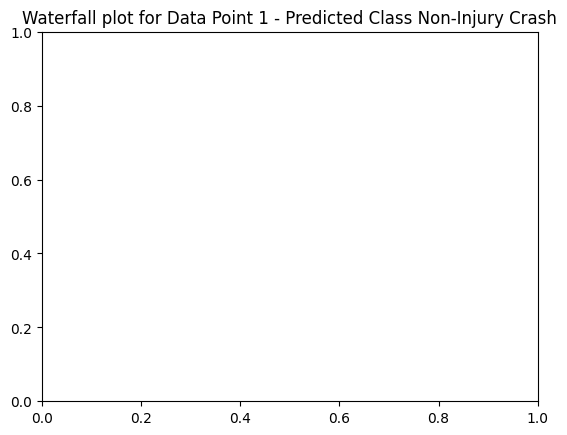

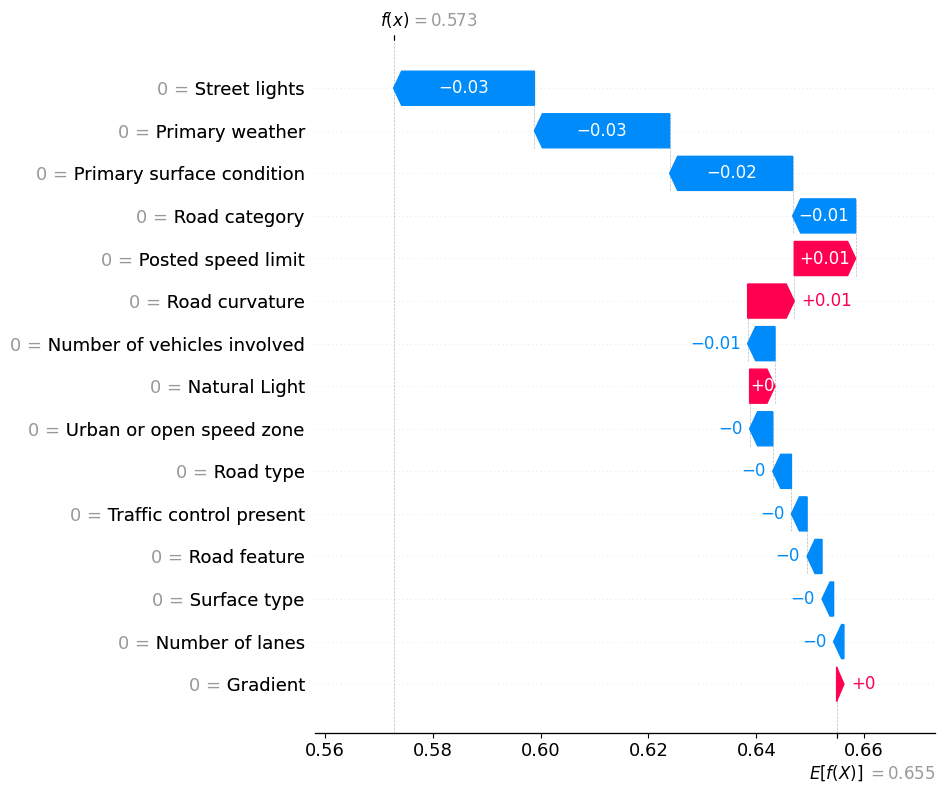

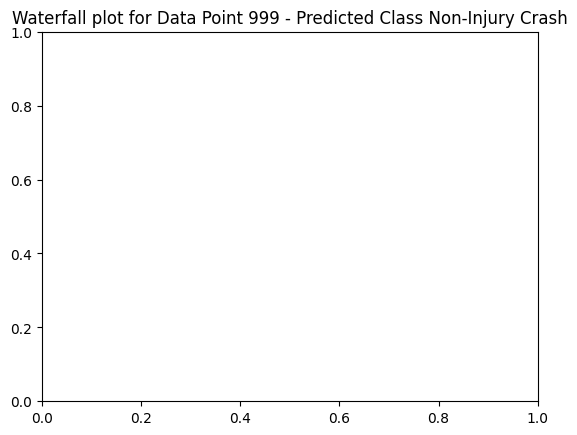

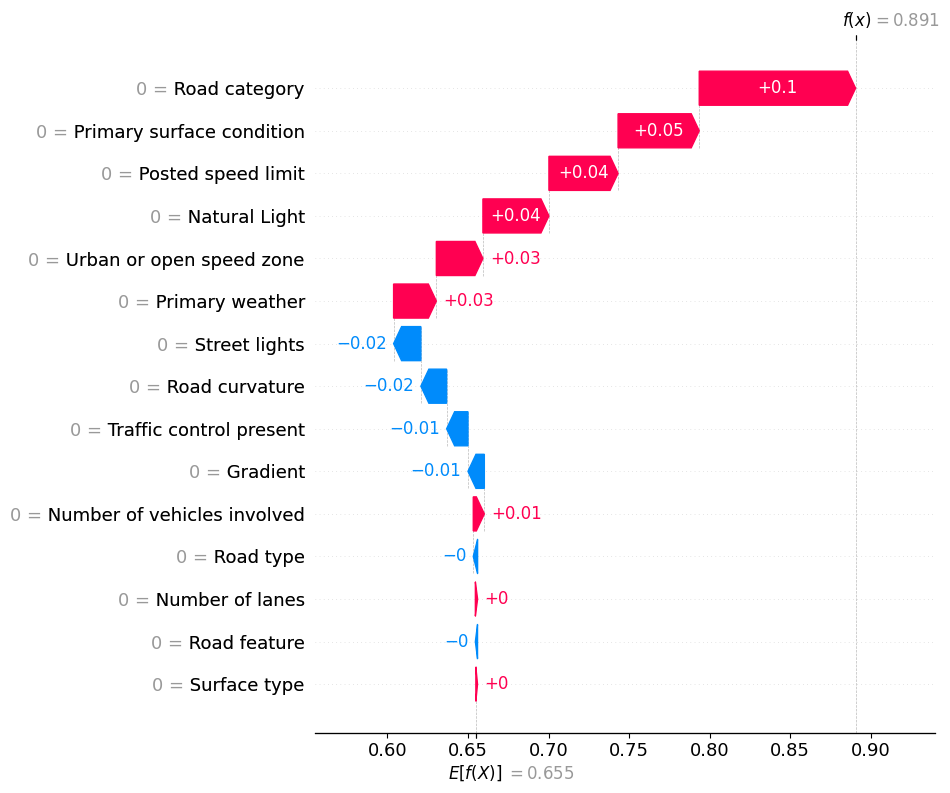

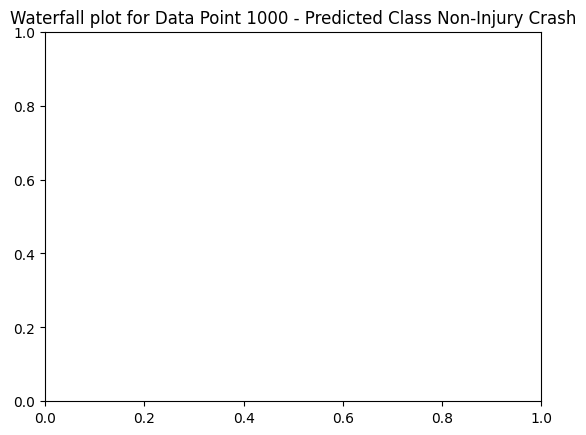

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming 'rf_clf' is your trained RandomForestClassifier
# Assuming 'X_train' and 'X_test' are your training and testing datasets

# Create SHAP explainer using the model and the training data
explainer = shap.Explainer(rf_clf, X_train)

# Function to aggregate and filter out zero SHAP values
def aggregate_and_filter_shap_values(shap_values, feature_names):
    aggregated_shap_values = {}
    for feature_name in feature_names:
        base_feature_name = feature_name.split('_')[0]
        if base_feature_name not in aggregated_shap_values:
            aggregated_shap_values[base_feature_name] = 0
        aggregated_shap_values[base_feature_name] += shap_values[feature_name]

    # Filter out features with a SHAP value of 0 and return
    return {k: v for k, v in aggregated_shap_values.items() if v != 0}

# Choose the data points you want to explain
data_point_indices = [0, 1, 999, 1000]  # Specify the indices of the data points you want to explain

# Loop through the specified data points
for data_point_index in data_point_indices:
    # Calculate SHAP Values for the specific data point
    shap_values_point = explainer(X_test.iloc[data_point_index:data_point_index+1, :])

    # Get the prediction of the model for this data point
    predicted_class_label = rf_clf.predict(X_test.iloc[data_point_index:data_point_index+1, :])[0]
    predicted_class_index = np.where(rf_clf.classes_ == predicted_class_label)[0][0]

    # Extract the SHAP values for the predicted class
    shap_values_for_pred_class = shap_values_point.values[0, :, predicted_class_index]
    expected_value = shap_values_point.base_values[0, predicted_class_index]

    # Aggregate and filter SHAP values
    filtered_shap_values = aggregate_and_filter_shap_values(
        dict(zip(X_test.columns, shap_values_for_pred_class)),
        X_test.columns
    )

    # If there are no non-zero SHAP values, skip plotting
    if not filtered_shap_values:
        print(f"No non-zero SHAP values for Data Point {data_point_index}")
        continue

    # Prepare values and names for the Explanation object
    values = np.array(list(filtered_shap_values.values()))
    feature_names = list(filtered_shap_values.keys())

    # Create an Explanation object with filtered SHAP values
    shap_explanation_filtered = shap.Explanation(
        values=values.reshape((1, len(values))),
        base_values=np.array([expected_value]),
        data=np.zeros((1, len(values))),
        feature_names=feature_names
    )

    # Create the waterfall plot with filtered values
    shap.plots.waterfall(shap_explanation_filtered[0], max_display=50)
    plt.title(f"Waterfall plot for Data Point {data_point_index} - Predicted Class {predicted_class_label}")
    plt.show()


In [ ]:
# Print all column names in X_test to inspect manually
for col in sampled_X_test.columns:
    print(col)



Road category_
Road category_Access rural
Road category_Access urban
Road category_Arterial rural
Road category_Arterial urban
Road category_Ferry car
Road category_Foot path
Road category_Foot track
Road category_Major rural
Road category_Major urban
Road category_Medium rural
Road category_Medium urban
Road category_Minor rural
Road category_Minor urban
Road category_Motorway
Road category_Vehicle track
Number of vehicles involved_1
Number of vehicles involved_2
Number of vehicles involved_3
Number of vehicles involved_4
Number of vehicles involved_5
Number of vehicles involved_6
Number of vehicles involved_7
Number of vehicles involved_8
Number of vehicles involved_9
Urban or open speed zone_
Urban or open speed zone_Open
Urban or open speed zone_Urban
Posted speed limit_
Posted speed limit_10.0
Posted speed limit_100.0
Posted speed limit_110.0
Posted speed limit_15.0
Posted speed limit_20.0
Posted speed limit_30.0
Posted speed limit_40.0
Posted speed limit_5.0
Posted speed limit_50

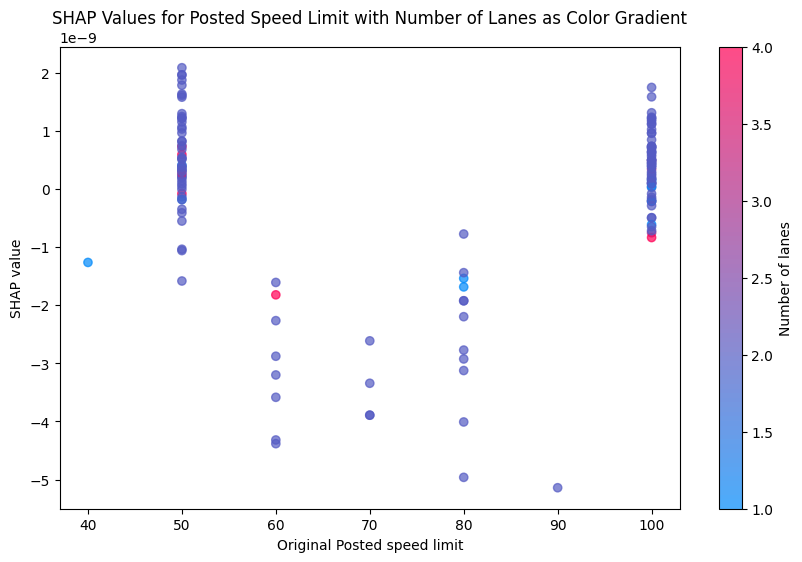

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to reverse one-hot encoding and reconstruct the original feature
def reverse_one_hot(df, feature_columns, original_feature_name):
    for col in feature_columns:
        df.loc[df[col] == 1, original_feature_name] = col.split('_')[-1]
    return df[original_feature_name].astype(float)  # Convert to float if the original feature was numeric

# Define the lists of column names for 'Posted speed limit' and 'Number of lanes'
posted_speed_limit_columns = [col for col in sampled_X_test.columns if col.startswith("Posted speed limit_")]
number_of_lanes_columns = [col for col in sampled_X_test.columns if col.startswith("Number of lanes_")]

# Reverse one-hot encoding for 'Posted speed limit' and 'Number of lanes'
sampled_X_test['Original Posted speed limit'] = reverse_one_hot(sampled_X_test, posted_speed_limit_columns, 'Posted speed limit')
sampled_X_test['Original Number of lanes'] = reverse_one_hot(sampled_X_test, number_of_lanes_columns, 'Number of lanes')

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
n_bins = 100  # Use more bins to make the color transition smoother
cmap_name = 'custom_blue_red'

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Extract SHAP values for 'Posted speed limit'
posted_speed_limit_shap_values = aggregated_shap_df['Posted speed limit'].values

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Normalize 'Number of lanes' values for color mapping
norm = mcolors.Normalize(vmin=sampled_X_test['Original Number of lanes'].min(), vmax=sampled_X_test['Original Number of lanes'].max())

# Scatter plot where color intensity is based on 'Number of lanes'
sc = plt.scatter(sampled_X_test['Original Posted speed limit'], posted_speed_limit_shap_values, c=sampled_X_test['Original Number of lanes'], norm=norm, cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Number of lanes')

# Setting plot labels and title
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit with Number of Lanes as Color Gradient')

# Show the plot
plt.show()


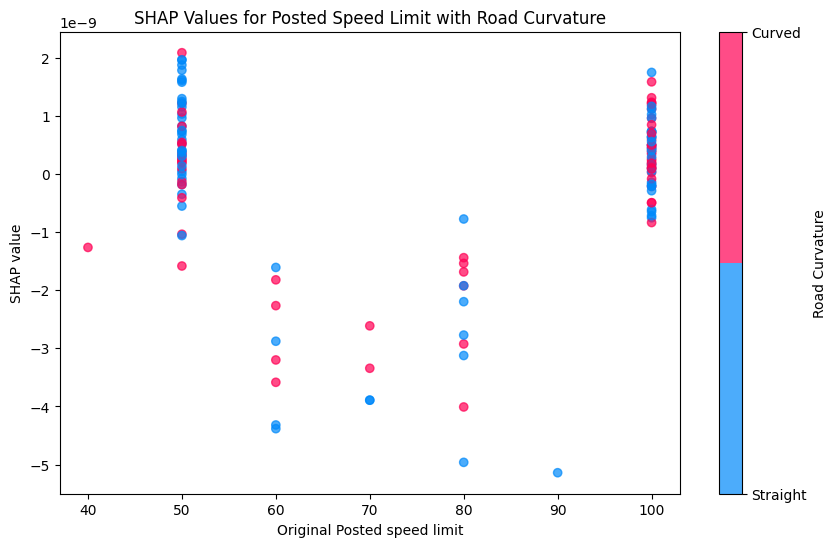

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to reverse one-hot encoding for 'Road curvature'
def reverse_one_hot_road_curvature(df):
    # Create a new column 'Curvature Type' with values 'Straight' or 'Curved'
    df['Curvature Type'] = np.where(df['Road curvature_Curved'] == 1, 'Curved', 'Straight')
    return df

# Apply the function to reverse one-hot encoding for the 'Road curvature' feature
sampled_X_test = reverse_one_hot_road_curvature(sampled_X_test)

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
n_bins = 100  # Use more bins to make the color transition smoother
cmap_name = 'custom_blue_red'

# Create the colormap
cm = LinearSegmentedColormap.from_list('Curvature_Colormap', colors, N=2)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Map 'Curvature Type' to a numerical value for color mapping
curvature_mapping = {'Straight': 0, 'Curved': 1}
sampled_X_test['Curvature Value'] = sampled_X_test['Curvature Type'].map(curvature_mapping)

# Scatter plot where color intensity is based on 'Curvature Type'
sc = plt.scatter(sampled_X_test['Original Posted speed limit'], posted_speed_limit_shap_values, c=sampled_X_test['Curvature Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label('Road Curvature')
cbar.set_ticklabels(['Straight', 'Curved'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit with Road Curvature')

# Show the plot
plt.show()


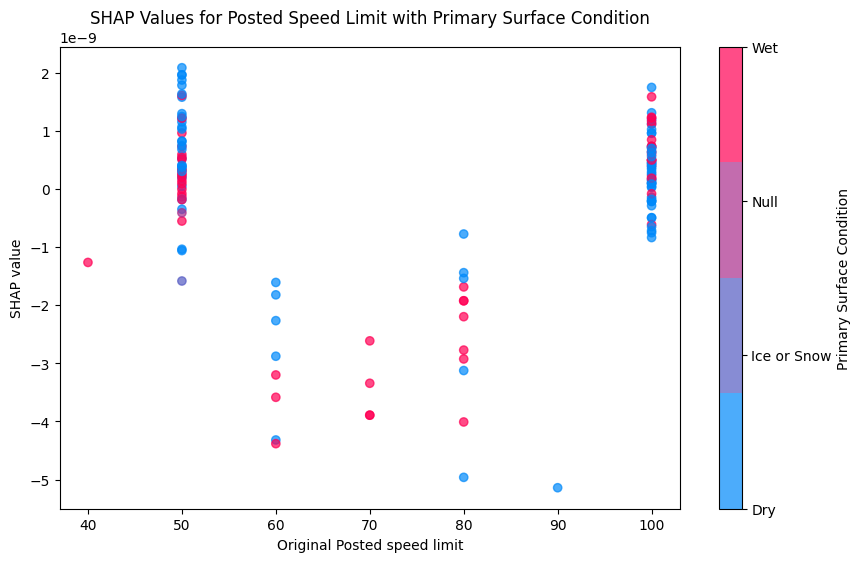

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to reverse one-hot encoding for 'Primary Surface Condition'
def reverse_one_hot_surface_condition(df):
    conditions = ['Dry', 'Ice or Snow', 'Null', 'Wet']
    condition_columns = [f'Primary surface condition_{cond}' for cond in conditions]
    # Extract the primary surface condition and return it as a Series
    return df[condition_columns].idxmax(axis=1).str.replace("Primary surface condition_", "")

# Apply the function to reverse one-hot encoding for the 'Primary Surface Condition'
sampled_X_test['Primary Surface Condition'] = reverse_one_hot_surface_condition(sampled_X_test)

# Define custom colors using RGBA values for the color gradient
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=4)



# Mapping surface conditions to numbers
condition_to_number = {'Dry': 0, 'Ice or Snow': 1, 'Null': 2, 'Wet': 3}
sampled_X_test['Surface Condition Number'] = sampled_X_test['Primary Surface Condition'].map(condition_to_number)

# Now use this 'Surface Condition Number' for color mapping in scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    sampled_X_test['Original Posted speed limit'],
    posted_speed_limit_shap_values,
    c=sampled_X_test['Surface Condition Number'],
    cmap=custom_cmap,
    alpha=0.7
)

# Rest of your plotting code remains the same
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Primary Surface Condition')
cbar.set_ticklabels(['Dry', 'Ice or Snow', 'Null', 'Wet'])
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit with Primary Surface Condition')
plt.show()




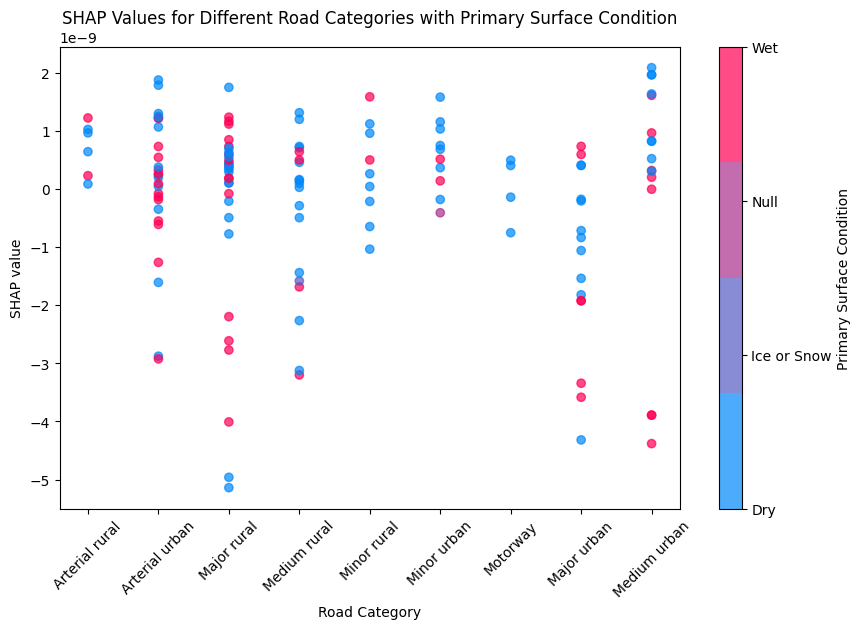

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

# Function to reverse one-hot encoding for 'Road Category'
def reverse_one_hot_road_category(df):
    road_category_columns = [col for col in df.columns if col.startswith("Road category_")]
    # Extract the road category and return it as a Series
    return df[road_category_columns].idxmax(axis=1).str.replace("Road category_", "")

# Function to reverse one-hot encoding for 'Primary Surface Condition'
def reverse_one_hot_surface_condition(df):
    conditions = ['Dry', 'Ice or Snow', 'Null', 'Wet']
    condition_columns = [f'Primary surface condition_{cond}' for cond in conditions]
    # Extract the primary surface condition and return it as a Series
    return df[condition_columns].idxmax(axis=1).str.replace("Primary surface condition_", "")

# Apply the function to reverse one-hot encoding for the 'Road Category'
sampled_X_test['Road Category'] = reverse_one_hot_road_category(sampled_X_test)

# Apply the function to reverse one-hot encoding for the 'Primary Surface Condition'
sampled_X_test['Primary Surface Condition'] = reverse_one_hot_surface_condition(sampled_X_test)

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
cm = LinearSegmentedColormap.from_list('SurfaceCondition_Colormap', colors, N=4)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Map 'Primary Surface Condition' to a numerical value for color mapping
surface_condition_mapping = {'Dry': 0, 'Ice or Snow': 1, 'Null': 2, 'Wet': 3}
sampled_X_test['Surface Condition Value'] = sampled_X_test['Primary Surface Condition'].map(surface_condition_mapping)

# Map 'Road Category' to numerical values for the x-axis
road_category_mapping = {cat: i for i, cat in enumerate(sampled_X_test['Road Category'].unique())}
sampled_X_test['Road Category Value'] = sampled_X_test['Road Category'].map(road_category_mapping)

# Scatter plot where color intensity is based on 'Primary Surface Condition'
sc = plt.scatter(sampled_X_test['Road Category Value'], posted_speed_limit_shap_values, c=sampled_X_test['Surface Condition Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Primary Surface Condition')
cbar.set_ticklabels(['Dry', 'Ice or Snow', 'Null', 'Wet'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Road Category')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Different Road Categories with Primary Surface Condition')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(road_category_mapping)), labels=road_category_mapping.keys(), rotation=45)

# Show the plot
plt.show()


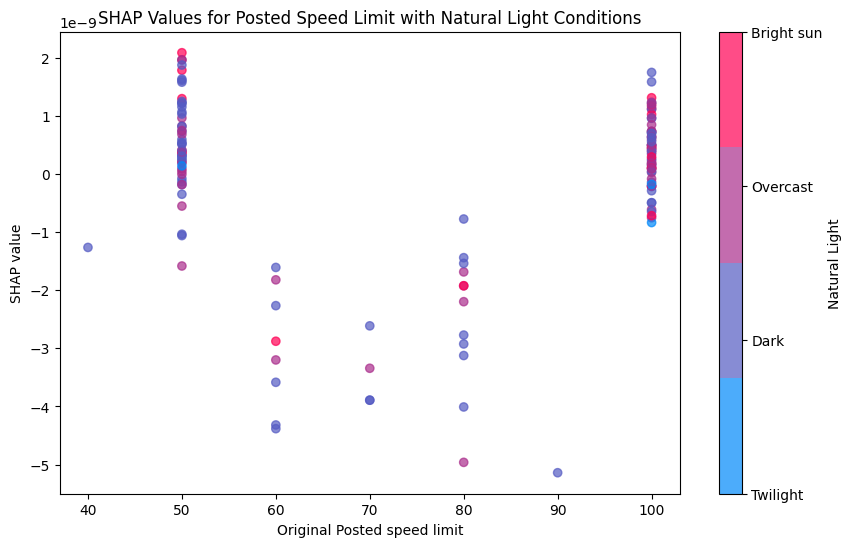

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

def reverse_one_hot_natural_light(df):
    # Define the natural light columns in the new order
    conditions = ['Twilight', 'Dark', 'Overcast', 'Bright sun']

    # Check if the columns exist in the DataFrame and create boolean arrays
    condition_values = [df.get(f'Natural Light_{cond}', pd.Series([False] * len(df))) == 1 for cond in conditions]

    # Use np.select to assign the natural light condition based on the boolean arrays
    df['Natural Light'] = np.select(condition_values, conditions, default='Unknown')
    return df

# Apply the function
sampled_X_test = reverse_one_hot_natural_light(sampled_X_test)

# Define custom colors using RGBA values for the color gradient
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=4)

# Create the colormap
cm = LinearSegmentedColormap.from_list("Custom_Colormap", colors, N=4)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Update the mapping to reflect the new order
natural_light_mapping = {'Twilight': 0, 'Dark': 1, 'Overcast': 2, 'Bright sun': 3}
sampled_X_test['Natural Light Value'] = sampled_X_test['Natural Light'].map(natural_light_mapping)

# Scatter plot where color intensity is based on 'Natural Light'
sc = plt.scatter(sampled_X_test['Original Posted speed limit'], posted_speed_limit_shap_values, c=sampled_X_test['Natural Light Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Natural Light')
cbar.set_ticklabels(['Twilight', 'Dark', 'Overcast', 'Bright sun'])  # Set custom labels in the new order

# Setting plot labels and title
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit with Natural Light Conditions')

# Show the plot
plt.show()


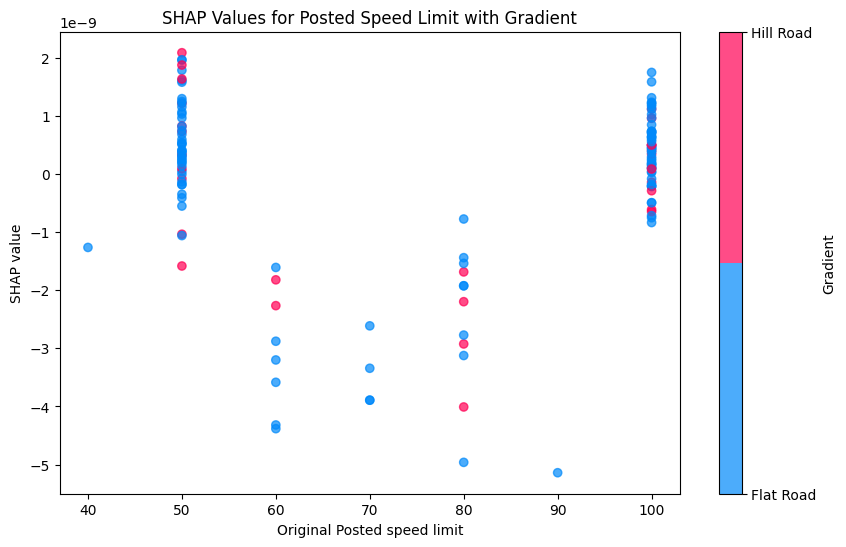

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to reverse one-hot encoding for 'Gradient'
def reverse_one_hot_gradient(df):
    # Create a new column 'Gradient Type' with values 'Flat' or 'Hill Road'
    df['Gradient Type'] = np.where(df['Gradient_Flat'] == 1, 'Flat', 'Hill Road')
    return df

# Apply the function to reverse one-hot encoding for the 'Gradient' feature
sampled_X_test = reverse_one_hot_gradient(sampled_X_test)

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
n_bins = 100  # Use more bins to make the color transition smoother
cmap_name = 'custom_blue_red'

# Create the colormap
cm = LinearSegmentedColormap.from_list('Gradient_Colormap', colors, N=2)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Map 'Gradient Type' to a numerical value for color mapping
gradient_mapping = {'Flat': 0, 'Hill Road': 1}
sampled_X_test['Gradient Value'] = sampled_X_test['Gradient Type'].map(gradient_mapping)

# Scatter plot where color intensity is based on 'Gradient Type'
sc = plt.scatter(sampled_X_test['Original Posted speed limit'], posted_speed_limit_shap_values, c=sampled_X_test['Gradient Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label('Gradient')
cbar.set_ticklabels(['Flat Road', 'Hill Road'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Original Posted speed limit')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Posted Speed Limit with Gradient')

# Show the plot
plt.show()


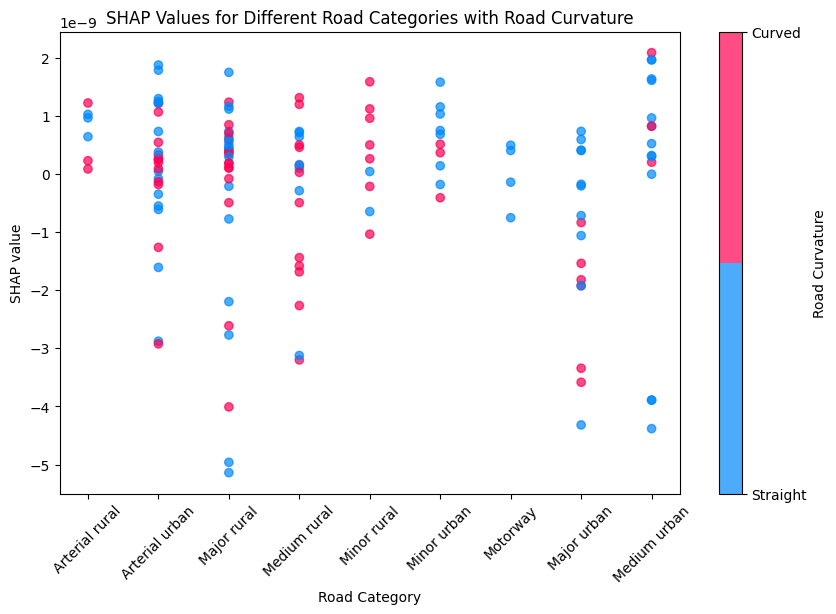

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to reverse one-hot encoding for 'Road Category'
def reverse_one_hot_road_category(df):
    road_category_columns = [col for col in df.columns if col.startswith("Road category_")]
    # Extract the road category and return it as a Series
    return df[road_category_columns].idxmax(axis=1).str.replace("Road category_", "")


# Apply the function to reverse one-hot encoding for the 'Road curvature' feature
sampled_X_test = reverse_one_hot_road_curvature(sampled_X_test)

# Apply the function to reverse one-hot encoding
sampled_X_test['Road Category'] = reverse_one_hot_road_category(sampled_X_test)

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
cm = LinearSegmentedColormap.from_list('Curvature_Colormap', colors, N=2)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Map 'Curvature Type' to a numerical value for color mapping
curvature_mapping = {'Straight': 0, 'Curved': 1}
sampled_X_test['Curvature Value'] = sampled_X_test['Curvature Type'].map(curvature_mapping)

# Map 'Road Category' to numerical values for the x-axis
road_category_mapping = {cat: i for i, cat in enumerate(sampled_X_test['Road Category'].unique())}
sampled_X_test['Road Category Value'] = sampled_X_test['Road Category'].map(road_category_mapping)

# Scatter plot where color intensity is based on 'Curvature Type'
sc = plt.scatter(sampled_X_test['Road Category Value'], posted_speed_limit_shap_values, c=sampled_X_test['Curvature Value'], cmap=cm, alpha=0.7)


# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.set_label('Road Curvature')
cbar.set_ticklabels(['Straight', 'Curved'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Road Category')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Different Road Categories with Road Curvature')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(road_category_mapping)), labels=road_category_mapping.keys(), rotation=45)

# Show the plot
plt.show()


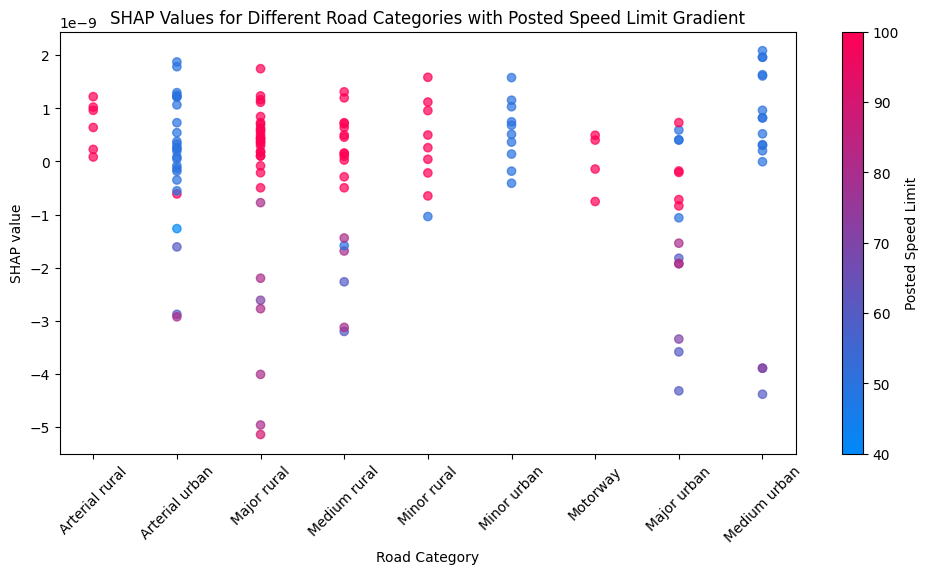

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Assuming 'sampled_X_test' and other necessary data and models are already defined in your script

# Function to extract original posted speed limit from one-hot encoded columns
def extract_original_speed_limit(df):
    speed_limit_columns = [col for col in df.columns if col.startswith("Posted speed limit_")]
    if not speed_limit_columns:
        print("No posted speed limit columns found.")
        return None
    df['Original Posted Speed Limit'] = df[speed_limit_columns].idxmax(axis=1).str.replace("Posted speed limit_", "").astype(float)
    return df

# Apply the function to extract original posted speed limit
sampled_X_test = extract_original_speed_limit(sampled_X_test)

# Ensure that 'Road Category' is present in your sampled_X_test DataFrame
# Map 'Road Category' to numerical values for the x-axis
road_category_mapping = {cat: i for i, cat in enumerate(sampled_X_test['Road Category'].unique())}
sampled_X_test['Road Category Value'] = sampled_X_test['Road Category'].map(road_category_mapping)

# Assuming 'posted_speed_limit_shap_values' contains the SHAP values corresponding to the posted speed limit
# Define the color map for 'Posted Speed Limit' using a custom blue to red colormap
speed_limit_values = sampled_X_test['Original Posted Speed Limit']
norm = plt.Normalize(speed_limit_values.min(), speed_limit_values.max())

# Define custom colors using RGBA values
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=256)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

# Create a scatter plot with a secondary y-axis for Posted Speed Limit
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for SHAP values with 'Road Category' on the x-axis
# Color intensity is based on 'Posted Speed Limit'
sc = ax1.scatter(sampled_X_test['Road Category Value'], posted_speed_limit_shap_values,
                 c=speed_limit_values, cmap=custom_cmap, alpha=0.7, norm=norm)

# Adding a colorbar for Posted Speed Limit
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Posted Speed Limit')

# Setting plot labels and title for the primary y-axis (left)
ax1.set_xlabel('Road Category')
ax1.set_ylabel('SHAP value')
ax1.set_title('SHAP Values for Different Road Categories with Posted Speed Limit Gradient')
ax1.set_xticks(np.arange(len(road_category_mapping)))
ax1.set_xticklabels(road_category_mapping.keys(), rotation=45)

plt.tight_layout()
plt.show()


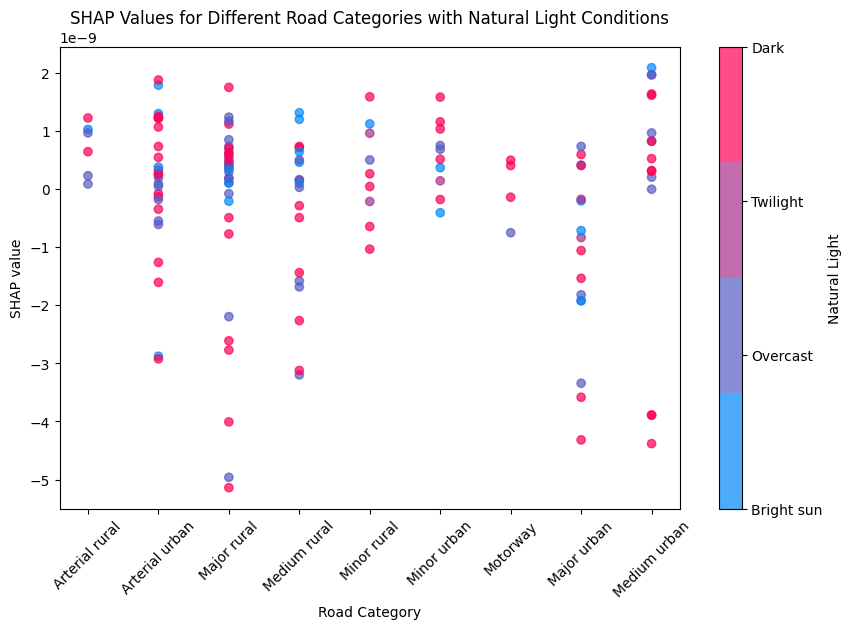

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

# Function to reverse one-hot encoding for 'Road Category'
def reverse_one_hot_road_category(df):
    road_category_columns = [col for col in df.columns if isinstance(col, str) and col.startswith("Road category_")]
    return df[road_category_columns].idxmax(axis=1).str.replace("Road category_", "")

# Function to reverse one-hot encoding for 'Natural Light'
def reverse_one_hot_natural_light(df):
    conditions = ['Bright sun', 'Dark', 'Overcast', 'Twilight']
    condition_columns = [f'Natural Light_{cond}' for cond in conditions]
    return df[condition_columns].idxmax(axis=1).str.replace("Natural Light_", "")

# Apply the function to reverse one-hot encoding for the 'Road Category'
sampled_X_test['Road Category'] = reverse_one_hot_road_category(sampled_X_test)

# Apply the function to reverse one-hot encoding for 'Natural Light'
sampled_X_test['Natural Light'] = reverse_one_hot_natural_light(sampled_X_test)

# Define custom colors using RGBA values
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=256)
cm = LinearSegmentedColormap.from_list('NaturalLight_CustomColormap', colors, N=4)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Update mapping with the new order and corresponding colors
natural_light_mapping = {'Bright sun': 0, 'Overcast': 1, 'Twilight': 2, 'Dark': 3}
sampled_X_test['Natural Light Value'] = sampled_X_test['Natural Light'].map(natural_light_mapping)

# Map 'Road Category' to numerical values for the x-axis
road_category_mapping = {cat: i for i, cat in enumerate(sampled_X_test['Road Category'].unique())}
sampled_X_test['Road Category Value'] = sampled_X_test['Road Category'].map(road_category_mapping)

# Scatter plot where color intensity is based on 'Natural Light'
sc = plt.scatter(sampled_X_test['Road Category Value'], posted_speed_limit_shap_values, c=sampled_X_test['Natural Light Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Natural Light')
cbar.set_ticklabels(['Bright sun', 'Overcast', 'Twilight', 'Dark'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Road Category')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Different Road Categories with Natural Light Conditions')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(road_category_mapping)), labels=road_category_mapping.keys(), rotation=45)

# Show the plot
plt.show()


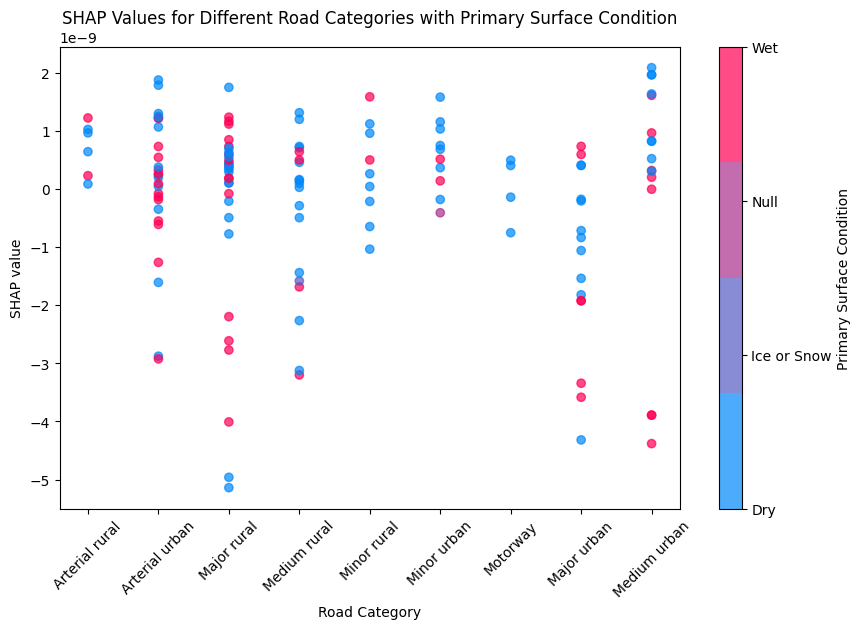

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd

# Function to reverse one-hot encoding for 'Road Category'
def reverse_one_hot_road_category(df):
    road_category_columns = [col for col in df.columns if col.startswith("Road category_")]
    # Extract the road category and return it as a Series
    return df[road_category_columns].idxmax(axis=1).str.replace("Road category_", "")

# Function to reverse one-hot encoding for 'Primary Surface Condition'
def reverse_one_hot_surface_condition(df):
    conditions = ['Dry', 'Ice or Snow', 'Null', 'Wet']
    condition_columns = [f'Primary surface condition_{cond}' for cond in conditions]
    # Extract the primary surface condition and return it as a Series
    return df[condition_columns].idxmax(axis=1).str.replace("Primary surface condition_", "")

# Apply the function to reverse one-hot encoding for the 'Road Category'
sampled_X_test['Road Category'] = reverse_one_hot_road_category(sampled_X_test)

# Apply the function to reverse one-hot encoding for the 'Primary Surface Condition'
sampled_X_test['Primary Surface Condition'] = reverse_one_hot_surface_condition(sampled_X_test)

# Define the colors using the RGBA values provided
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
cm = LinearSegmentedColormap.from_list('SurfaceCondition_Colormap', colors, N=4)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Map 'Primary Surface Condition' to a numerical value for color mapping
surface_condition_mapping = {'Dry': 0, 'Ice or Snow': 1, 'Null': 2, 'Wet': 3}
sampled_X_test['Surface Condition Value'] = sampled_X_test['Primary Surface Condition'].map(surface_condition_mapping)

# Map 'Road Category' to numerical values for the x-axis
road_category_mapping = {cat: i for i, cat in enumerate(sampled_X_test['Road Category'].unique())}
sampled_X_test['Road Category Value'] = sampled_X_test['Road Category'].map(road_category_mapping)

# Scatter plot where color intensity is based on 'Primary Surface Condition'
sc = plt.scatter(sampled_X_test['Road Category Value'], posted_speed_limit_shap_values, c=sampled_X_test['Surface Condition Value'], cmap=cm, alpha=0.7)

# Adding a colorbar
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Primary Surface Condition')
cbar.set_ticklabels(['Dry', 'Ice or Snow', 'Null', 'Wet'])  # Set custom labels

# Setting plot labels and title
plt.xlabel('Road Category')
plt.ylabel('SHAP value')
plt.title('SHAP Values for Different Road Categories with Primary Surface Condition')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(road_category_mapping)), labels=road_category_mapping.keys(), rotation=45)

# Show the plot
plt.show()


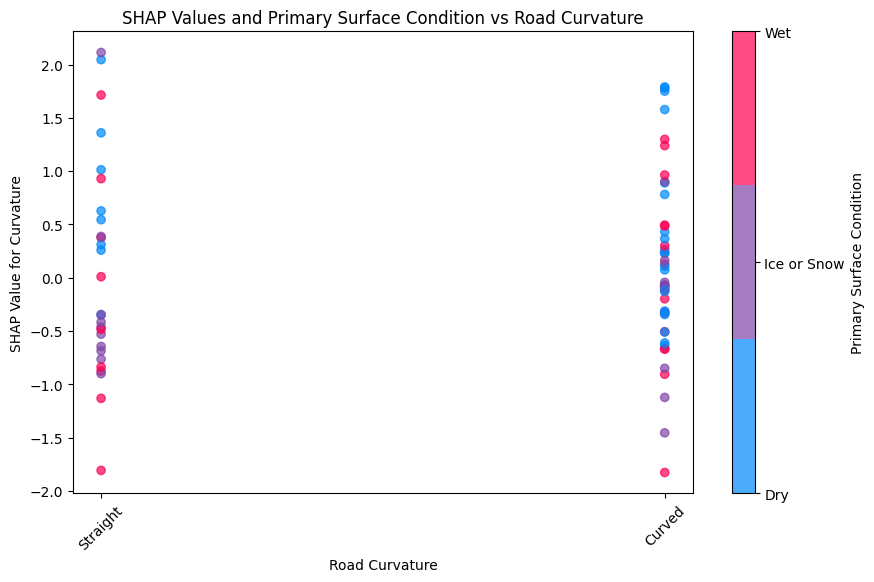

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Function to reverse one-hot encoding for 'Road Curvature'
def reverse_one_hot_road_curvature(df):
    conditions = [
        df['Road curvature_Curved'] == 1,
        df['Road curvature_Straight'] == 1
    ]
    choices = ['Curved', 'Straight']
    df['Curvature Type'] = np.select(conditions, choices, default=np.nan)
    return df

# Assuming 'sampled_X_test' is defined elsewhere and includes necessary columns
sampled_X_test = pd.DataFrame({
    'Road curvature_Curved': np.random.randint(0, 2, size=100),
    'Road curvature_Straight': np.random.randint(0, 2, size=100),
    'Primary Surface Condition': np.random.choice(['Dry', 'Ice or Snow', 'Wet'], size=100)
})

# Apply the function to reverse one-hot encoding for 'Road Curvature'
sampled_X_test = reverse_one_hot_road_curvature(sampled_X_test)

# Filter out 'Unknown' and 'Null' curvature types
sampled_X_test = sampled_X_test.dropna(subset=['Curvature Type'])

# Map 'Curvature Type' to a numerical value for color mapping
curvature_mapping = {'Straight': 0, 'Curved': 1}
sampled_X_test['Curvature Value'] = sampled_X_test['Curvature Type'].map(curvature_mapping)

# Map 'Primary Surface Condition' to numerical values for the color gradient
surface_conditions = ['Dry', 'Ice or Snow', 'Wet']
surface_condition_mapping = {cond: i for i, cond in enumerate(surface_conditions)}
sampled_X_test['Primary Surface Condition Value'] = sampled_X_test['Primary Surface Condition'].map(surface_condition_mapping)

# Normalize the 'Primary Surface Condition Value' for color mapping
norm = plt.Normalize(min(surface_condition_mapping.values()), max(surface_condition_mapping.values()))

# Define custom colors using RGBA values for the color gradient
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=3)

# Assuming 'shap_values_curvature' is defined elsewhere
shap_values_curvature = np.random.randn(len(sampled_X_test))  # Replace with actual SHAP values

# Create a scatter plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for SHAP values with 'Curvature Type' on the x-axis and color based on 'Primary Surface Condition'
sc = ax1.scatter(sampled_X_test['Curvature Value'], shap_values_curvature, c=sampled_X_test['Primary Surface Condition Value'], cmap=custom_cmap, norm=norm, alpha=0.7)
ax1.set_ylabel('SHAP Value for Curvature')

# Adding a colorbar for 'Primary Surface Condition'
cbar = plt.colorbar(sc, ax=ax1, norm=norm, ticks=range(len(surface_conditions)))
cbar.set_label('Primary Surface Condition')
cbar.set_ticklabels(surface_conditions)

# Setting plot labels and title
ax1.set_xlabel('Road Curvature')
ax1.set_title('SHAP Values and Primary Surface Condition vs Road Curvature')

# Set x-axis ticks and labels
ax1.set_xticks(np.arange(len(curvature_mapping)))
ax1.set_xticklabels(curvature_mapping.keys(), rotation=45)

# Show the plot
plt.show()


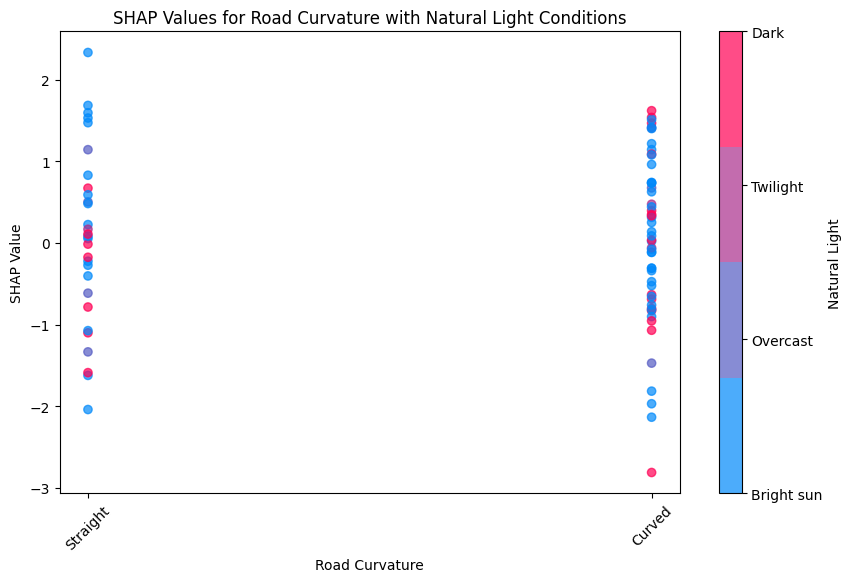

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Function to reverse one-hot encoding for 'Road Curvature'
def reverse_one_hot_road_curvature(df):
    conditions = [
        df['Road curvature_Curved'] == 1,
        df['Road curvature_Straight'] == 1
    ]
    choices = ['Curved', 'Straight']
    df['Curvature Type'] = np.select(conditions, choices, default=np.nan)
    return df

# Function to reverse one-hot encoding for 'Natural Light'
def reverse_one_hot_natural_light(df):
    conditions = ['Bright sun', 'Dark', 'Overcast', 'Twilight']
    condition_columns = [f'Natural Light_{cond}' for cond in conditions]
    return df[condition_columns].idxmax(axis=1).str.replace("Natural Light_", "")

# Create a dummy DataFrame for demonstration
sampled_X_test = pd.DataFrame({
    'Road curvature_Curved': np.random.randint(0, 2, size=100),
    'Road curvature_Straight': np.random.randint(0, 2, size=100),
    'Natural Light_Bright sun': np.random.randint(0, 2, size=100),
    'Natural Light_Overcast': np.random.randint(0, 2, size=100),
    'Natural Light_Twilight': np.random.randint(0, 2, size=100),
    'Natural Light_Dark': np.random.randint(0, 2, size=100),
    # ... other features ...
})

# Apply the function to reverse one-hot encoding for 'Road Curvature'
sampled_X_test = reverse_one_hot_road_curvature(sampled_X_test)

# Apply the function to reverse one-hot encoding for 'Natural Light'
sampled_X_test['Natural Light'] = reverse_one_hot_natural_light(sampled_X_test)

# Map 'Curvature Type' to a numerical value for the x-axis
curvature_mapping = {'Straight': 0, 'Curved': 1}
sampled_X_test['Curvature Value'] = sampled_X_test['Curvature Type'].map(curvature_mapping)

# Map 'Natural Light' to numerical values for the color gradient
natural_light_mapping = {'Bright sun': 0, 'Overcast': 1, 'Twilight': 2, 'Dark': 3}
sampled_X_test['Natural Light Value'] = sampled_X_test['Natural Light'].map(natural_light_mapping)

# Define custom colors using RGBA values for the color gradient
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('NaturalLight_CustomColormap', colors, N=4)

# Assuming 'shap_values_curvature' is defined elsewhere
# For the demonstration, create a random array of SHAP values
shap_values_curvature = np.random.randn(len(sampled_X_test))  # Replace with actual SHAP values

# Create a scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(sampled_X_test['Curvature Value'], shap_values_curvature, c=sampled_X_test['Natural Light Value'], cmap=custom_cmap, alpha=0.7)

# Adding a colorbar for 'Natural Light'
cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.set_label('Natural Light')
cbar.set_ticklabels(['Bright sun', 'Overcast', 'Twilight', 'Dark'])

# Setting plot labels and title
plt.xlabel('Road Curvature')
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Road Curvature with Natural Light Conditions')

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(curvature_mapping)), labels=curvature_mapping.keys(), rotation=45)

# Show the plot
plt.show()


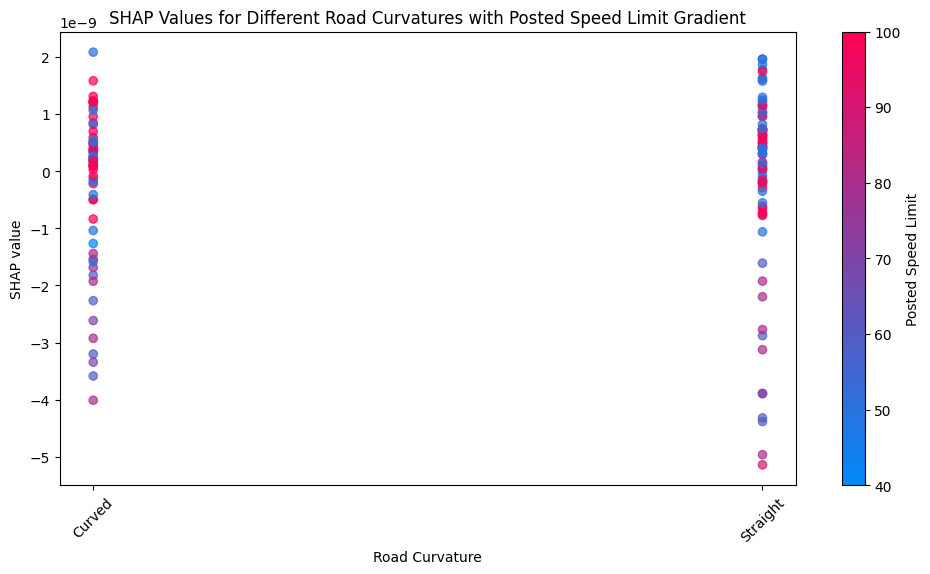

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Function to aggregate 'Road Curvature' from one-hot encoded columns
def aggregate_road_curvature(df):
    curvature_columns = [col for col in df.columns if col.startswith("Road curvature_")]
    # Create a new column for the original road curvature
    df['Aggregated Road Curvature'] = df[curvature_columns].idxmax(axis=1).str.replace("Road curvature_", "")
    return df

# Function to extract original posted speed limit from one-hot encoded columns
def extract_original_speed_limit(df):
    speed_limit_columns = [col for col in df.columns if col.startswith("Posted speed limit_")]
    if not speed_limit_columns:
        print("No posted speed limit columns found.")
        return None
    df['Original Posted Speed Limit'] = df[speed_limit_columns].idxmax(axis=1).str.replace("Posted speed limit_", "").astype(float)
    return df

# Apply the function to extract original posted speed limit
sampled_X_test = extract_original_speed_limit(sampled_X_test)

# Apply the function to aggregate road curvature
sampled_X_test = aggregate_road_curvature(sampled_X_test)

# Map 'Aggregated Road Curvature' to numerical values for the x-axis
road_curvature_mapping = {curvature: i for i, curvature in enumerate(sampled_X_test['Aggregated Road Curvature'].unique())}
sampled_X_test['Road Curvature Value'] = sampled_X_test['Aggregated Road Curvature'].map(road_curvature_mapping)

# Define the color map for 'Posted Speed Limit' using a custom blue to red colormap
speed_limit_values = sampled_X_test['Original Posted Speed Limit']
norm = plt.Normalize(speed_limit_values.min(), speed_limit_values.max())

# Define custom colors using RGBA values
colors = [(0, 137/255, 250/255, 1), (255/255, 0, 85/255, 1)]  # Blue to Red
custom_cmap = LinearSegmentedColormap.from_list('BlueRed_Colormap', colors, N=256)

# ... rest of the code ...


sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

# Create a scatter plot with a secondary y-axis for Posted Speed Limit
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for SHAP values with 'Road Curvature' on the x-axis
# Color intensity is based on 'Posted Speed Limit'
sc = ax1.scatter(sampled_X_test['Road Curvature Value'], posted_speed_limit_shap_values,
                 c=speed_limit_values, cmap=custom_cmap, alpha=0.7, norm=norm)

# Adding a colorbar for Posted Speed Limit
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Posted Speed Limit')

# Setting plot labels and title for the primary y-axis (left)
ax1.set_xlabel('Road Curvature')
ax1.set_ylabel('SHAP value')
ax1.set_title('SHAP Values for Different Road Curvatures with Posted Speed Limit Gradient')
ax1.set_xticks(np.arange(len(road_curvature_mapping)))
ax1.set_xticklabels(road_curvature_mapping.keys(), rotation=45)

plt.tight_layout()
plt.show()
